C:\Users\administer\AppData\Local\Temp\ipykernel_39832\94421050.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


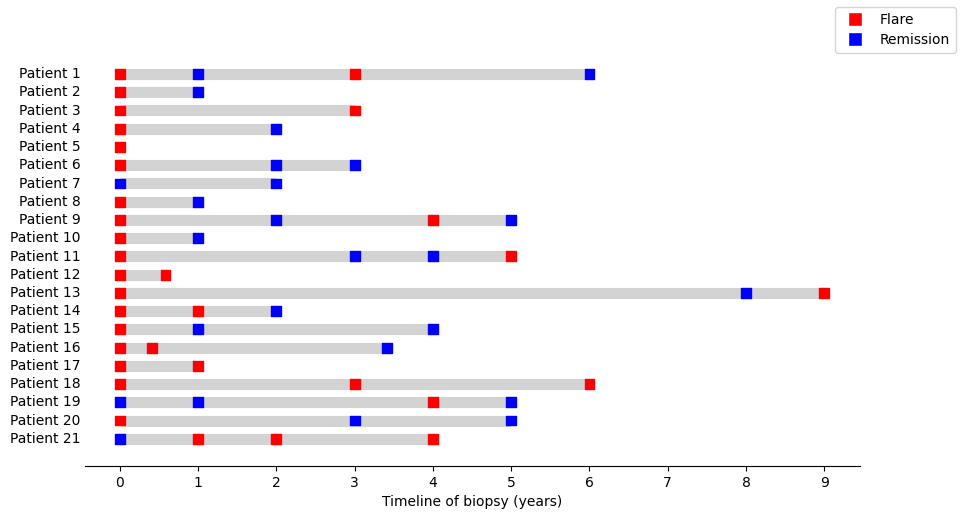

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# load data
file_path = '/pigeon/data/patient_information.xlsx'  # need to change to your file path
patient_data = pd.read_excel(file_path)

# inplace NaN values
patient_data.dropna(how='all', inplace=True)

# fill NaN values in 'Number' column
patient_data['Number'] = patient_data['Number'].ffill()

# add 'Status' column
df_fr = pd.read_csv('/pigeon/ehr/index.csv')
patient_data.reset_index(drop=True, inplace=True)
df_fr.reset_index(drop=True, inplace=True)
patient_data = pd.concat([patient_data, df_fr[['Disease State']].rename(columns={'Disease State': 'Status'})], axis=1)
# print(patient_data)

# convert 'Time from previous colonoscopy (years)' to numeric
patient_data['Time from previous colonoscopy (years)'] = pd.to_numeric(
    patient_data['Time from previous colonoscopy (years)'], errors='coerce'
)

file_path = '/pigeon/data/patient_information_with_status.csv'  # should be updated
patient_data.to_csv(file_path, index=False)

# group by 'Number' column
grouped = patient_data.groupby('Number')

'''
plot a timeline for each patient, 
where the x-axis represents the cumulative time from the previous colonoscopy,
red points represent the 'Flare' state, and blue points represent the 'Remission' state.
'''
fig, axes = plt.subplots(len(grouped) + 1, 1, figsize=(10, 0.2 * len(grouped) + 1), sharex=True, 
                         gridspec_kw={'hspace': 0.05})

for idx, (patient_num, group) in enumerate(grouped):
    # calculate the cumulative time
    cumulative_time = group['Time from previous colonoscopy (years)'].fillna(0).cumsum()
    
    # plot the timeline
    ax = axes[idx] if len(grouped) > 1 else axes
    ax.plot([0, cumulative_time.iloc[-1]], [0, 0], color='lightgray', linewidth=8, solid_capstyle='butt') 
    colors = group['Status'].replace({'F': 'red', 'R': 'blue'}).values 
    ax.scatter(cumulative_time, [0] * len(cumulative_time), c=colors, s=50, zorder=5, marker='s') 

    ax.axis('off')
    ax.text(-0.5, 0, f'Patient {int(patient_num)}', va='center', ha='right', fontsize=10, color='black')

time_ax = axes[-1]
time_ax.set_xlabel('Timeline of biopsy (years)')
time_ax.yaxis.set_visible(False)
time_ax.spines['top'].set_visible(False)
time_ax.spines['right'].set_visible(False)
time_ax.spines['left'].set_visible(False)

# Set the interval for the x-axis ticks
tick_interval = 1
time_ax.xaxis.set_major_locator(MultipleLocator(tick_interval))

# Add legend
red_patch = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Flare')
blue_patch = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Remission')
fig.legend(handles=[red_patch, blue_patch], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()